# Making stacked histograms
- processes an `events[year][ch][sample]` object using `make_events_dict()`
- uses `plot_hists()` to make stacked histograms

In [28]:
import glob
import os
import json
import pickle
import yaml
import math

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import sys
sys.path
sys.path.append("../python/")

import utils

plt.rcParams.update({"font.size": 20})

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# get lumi
with open("../fileset/luminosity.json") as f:
    luminosity = json.load(f)
    
luminosity

{'ele': {'Run2': 137640.0,
  '2016APV': 19492.72,
  '2016': 16809.96,
  '2017': 41476.02,
  '2018': 59816.23},
 'mu': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'lep': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96},
 'had': {'Run2': 137640.0,
  '2016APV': 19436.16,
  '2016': 16810.81,
  '2017': 41475.26,
  '2018': 59781.96}}

In [31]:
def get_lumi(years, channels):
    lum_ = 0
    for year in years:
        lum = 0
        for ch in channels:
            lum += luminosity[ch][year] / 1000.0

        lum_ += lum / len(channels)    
    return lum_

In [32]:
def rename_column(ev_dict, old_name, new_name):
    for year in ev_dict:
        for ch in ev_dict[year]:
            for sample in ev_dict[year][ch]:
                df = ev_dict[year][ch][sample]
                df[new_name] = df[old_name]
                
                # drop old column
                df = df[df.columns.drop(list(df.filter(regex=old_name)))]

# tagger_old = "fj_ParT_score_finetuned_v2_1-12"
# tagger_new = "fj_ParT_score_finetuned_v2_1_12"
# rename_column(events_dict, tagger_old, tagger_new)                

In [33]:
 # define your regions here
presel = {
        # "mu": {
        #     "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
        #     "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
        #     "fj_pt300": "( ( fj_pt>250) )",   
        #     "dphi<1.57": "(abs_met_fj_dphi<1.57)",
        #     "tagger>0.5": "fj_ParT_score_finetuned>0.5",
        #     "MET>25": "met_pt>25",
        # },
        # "ele": {
        #     "lep_fj_dr003": "( ( lep_fj_dr>0.03) )", 
        #     "lep_fj_dr08": "( ( lep_fj_dr<0.8) )",   
        #     "fj_pt300": "( ( fj_pt>250) )", 
        #     "dphi<1.57": "(abs_met_fj_dphi<1.57)",
        #     "tagger>0.5": "fj_ParT_score_finetuned>0.5",  
        #     "MET>30": "met_pt>30",            
        # },
    "had":{
            "lepptcut": "lepPt>0"
    }
}

from make_stacked_hists import make_events_dict
# channels = ["ele", "mu"]
channels = ["had"]
samples = [
    # "ggF", 
    # "VH",
    # "VBF",
    # "ttH",
    "QCD",
    # "DYJets",
    # "WJetsLNu",
    # "WZQQ",
    "TTbar",
    # "SingleTop",
    # "Diboson",
    "Data"
]

In [34]:
events_dict = {}

In [35]:
### new corrections
samples_dir = {
    "2016":    "/eos/uscms/store/user/aaportel/boostedhiggs/feb_12_sf_small_inference_2016/",
    # "2016APV": "/eos/uscms/store/user/aaportel/boostedhiggs/feb_",
    # "2017":    "/eos/uscms/store/user/aaportel/boostedhiggs/feb_",
    # "2018":    "/eos/uscms/store/user/aaportel/boostedhiggs/feb_",
}

# years = ["2017", "2016", "2016APV", "2018"]
years = ["2016"]
for year in years:

    out = make_events_dict([year], channels, samples_dir[year], samples, presel, region="signal_region")
    events_dict = {**events_dict, **out}

INFO:root:Finding JetHT_Run2016F samples and should combine them under Data
INFO:root:Applying lepptcut selection on 1780 events
INFO:root:Will fill the Data dataframe with the remaining 52 events
INFO:root:tot event weight 52.0 

INFO:root:Finding JetHT_Run2016G samples and should combine them under Data
INFO:root:Applying lepptcut selection on 19647 events
INFO:root:Will fill the Data dataframe with the remaining 608 events
INFO:root:tot event weight 608.0 

INFO:root:Finding JetHT_Run2016H samples and should combine them under Data
INFO:root:Applying lepptcut selection on 37718 events
INFO:root:Will fill the Data dataframe with the remaining 1221 events
INFO:root:tot event weight 1221.0 

INFO:root:Finding QCD_Pt_1000to1400 samples and should combine them under QCD
INFO:root:---> Using already stored event weight
INFO:root:Applying lepptcut selection on 54754 events
INFO:root:Will fill the QCD dataframe with the remaining 837 events
INFO:root:tot event weight 5.2866597175598145 

IN

In [60]:
events_dict['2016']['had']['TTbar']['had_fatjetPt']

24       1095.0
34        549.0
45        487.0
51        627.5
74        460.5
          ...  
60907     706.0
60911     455.5
60912     533.5
60914     510.5
60916    1109.0
Name: had_fatjetPt, Length: 39315, dtype: float32

In [37]:
dominant_backgrounds = ["WJetsLNu", "TTbar", "QCD", "DYJets"]
def get_composition_table(ev, tagger, presel, years, channels):

    num_sig = {
        "ggF": 0, 
        "ttH": 0, 
        "VH": 0,
        "VBF": 0,
    }
    num_bkg = {
        "WJetsLNu": 0, 
        "TTbar": 0, 
        "QCD": 0,
        "DYJets": 0,
        "Others": 0,
    }

    deno_sig, deno_bkg = 0, 0

    samples = [
        "ggF", 
        "VH",
        "VBF",
        "ttH",
        "QCD",
        "DYJets",
        "WJetsLNu",
        "WZQQ",
        "TTbar",
        "SingleTop",
        "Diboson",
        "Data"
    ]

    for year in years:
        for ch in channels:
            for sample in samples:
                if sample=="Data":
                    continue

                region, sel = list(presel.items())[0]

                df = ev[year][ch][sample]

                df = df.query(sel)  

                ######################## composition start
                if sample in utils.signals:

                    deno_sig += df["event_weight"].sum()
                    num_sig[sample] += df["event_weight"].sum()
                else:
                    deno_bkg += df["event_weight"].sum()

                    if sample in dominant_backgrounds:
                        num_bkg[sample] += df["event_weight"].sum()
                    else:
                        num_bkg["Others"] += df["event_weight"].sum()     
                ######################## composition end


    num_sig = dict(sorted(num_sig.items(), key=lambda item: item[1]))
    num_bkg = dict(sorted(num_bkg.items(), key=lambda item: item[1]))

    if len(years) == 4:
        lab = "RUN2"
    else:
        lab = "_".join(years)

    print("\033[1m" + f"{list(presel.keys())[0]} ({lab}):" + '\033[0m')

    print("------------------------")

    print(f"Signal: {deno_sig:.2f}")
    for sample in num_sig:
        print(f"- {sample}: {100*(num_sig[sample]/deno_sig):.0f}%")

    print("------------------------")
    print(f"Background: {deno_bkg:.2f}")
    for sample in num_bkg:
        if sample=="":
            print("\033[1m" + f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")
        else:
            print(f"- {sample}: {100*(num_bkg[sample]/deno_bkg):.0f}%")             

# Stacked hists

In [38]:
def fix_neg_yields(h):
    """
    Will set the bin yields of a process to 0 if the nominal yield is negative, and will
    set the yield to 0 for the full Systematic axis.
    """
    for sample in h.axes["samples"]:
        neg_bins = np.where(h[{"samples": sample}].values() < 0)[0]

        if len(neg_bins) > 0:
            print(f"{sample}, has {len(neg_bins)} bins with negative yield.. will set them to 0")

            sample_index = np.argmax(np.array(h.axes["samples"]) == sample)

            for neg_bin in neg_bins:
                h.view(flow=True)[sample_index, neg_bin + 1] = 0

In [65]:
vars_to_plot = [
#     "fj_minus_lep_m",
    # "fj_pt",
#     "lep_pt",
#     "lep_fj_dr",
#     "lep_met_mt",
#     "met_fj_dphi",
#     "met",    
    # "rec_higgs_m",
#     "fj_msoftdrop",    
    # "fj_ParT_mass",
    # "fj_ParT_score",
    # 'lepPt',
    "lep_fatjetPt",
    "had_fatjetPt",
]

samples_to_plot = [
    # "ggF", 
    # "VH",
    # "VBF",
    # "ttH",
    "QCD",
    # "DYJets",
    # "WJetsLNu",
    # "WZQQ",
    "TTbar",
    # "SingleTop",
    # "Diboson",
    "Data",
]

# samples_to_plot = [
#     # "ggF", 
#     # "VH",
#     # "VBF",
#     # "ttH",
#     "QCD",
#     # "DYJets",
#     # "WJetsLNu",
#     # "WZQQ",
#     "TTbarMatched",
#     "TTbarUnmatched",
#     # "SingleTop",
#     # "Diboson",
#     "Data",
# ]

In [66]:
axis_dict = {
    "lep_fatjetPt": hist2.axis.Regular(40, 450, 1000, name="var", label=r"Leptonic Fat Jet $p_T$ [GeV]", overflow=True),
    "had_fatjetPt": hist2.axis.Regular(40, 450, 1000, name="var", label=r"Hadronic Fat Jet $p_T$ [GeV]", overflow=True),
    "lepPt": hist2.axis.Regular(40, 30, 450, name="var", label=r"Lepton $p_T$ [GeV]", overflow=True),
    "fj_ParT_mass": hist2.axis.Regular(20, 0, 250, name="var", label=r"ParT regressed mass [GeV]", overflow=True),
    "fj_ParT_score": hist2.axis.Regular(35, 0, 1, name="var", label=r"tagger score", overflow=True),

}

tagger = "fj_ParT_score"
# tagger = "fj_ParT_score_finetuned"

presel = {
#     "Pre-selection": f"{tagger}>0.5",
    #### put any selection you want, e.g.:
    # "top cut": "( (n_bjets_T>=1) & (fj_pt>300) ) | (lep_pt>300)", 

    "lepptcut": "lepPt>0"

}

# channels = ["ele", "mu"]
channels = ["had"]
# years = ["2018", "2017", "2016", "2016APV"]
years = ["2016"]

# fill histograms
hists = {}

ev = events_dict
for var in vars_to_plot:

    hists[var] = hist2.Hist(
        hist2.axis.StrCategory([], name="samples", growth=True),
        axis_dict[var],
    )        
        
    for sample in samples_to_plot:
        for year in years:
            for ch in channels:

                # if 'TTbarMatched' in sample:
                #     ev[year][ch]['TTbar'] # ttbar to cut here, 
                # else:
                
                region, sel = list(presel.items())[0]
                
                df = ev[year][ch][sample]

                df = df.query(sel)

                hists[var].fill(
                    samples=sample,
                    var=df[var],
                    weight=df["event_weight"],
                )     
    
# for var in vars_to_plot:
#     fix_neg_yields(hists[var])

Will plot lep_fatjetPt histogram
Will plot had_fatjetPt histogram



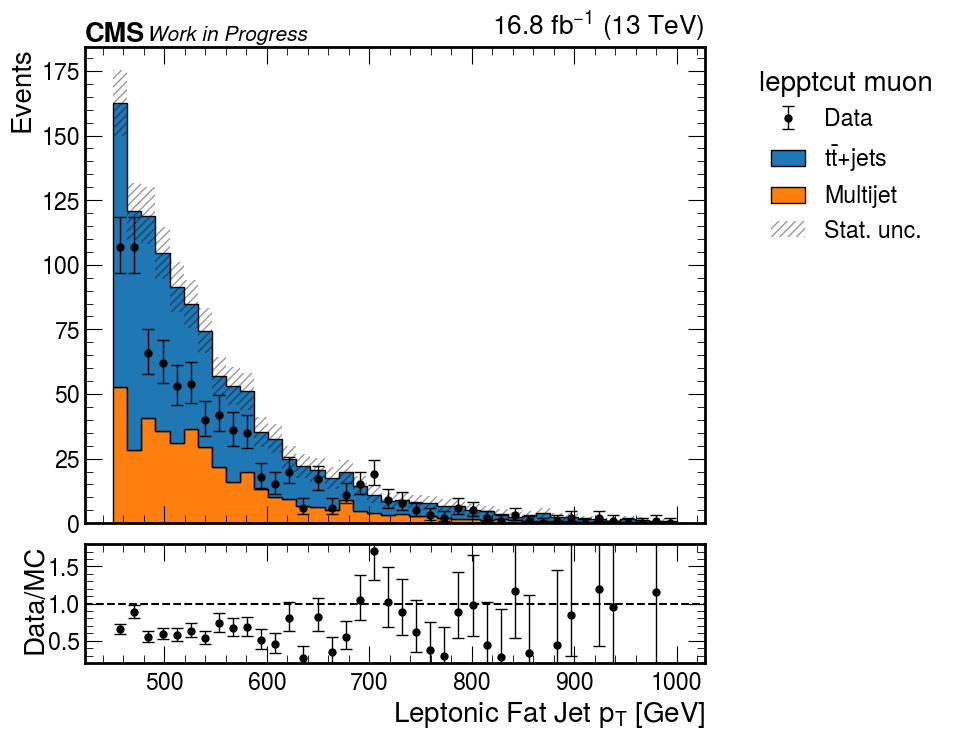

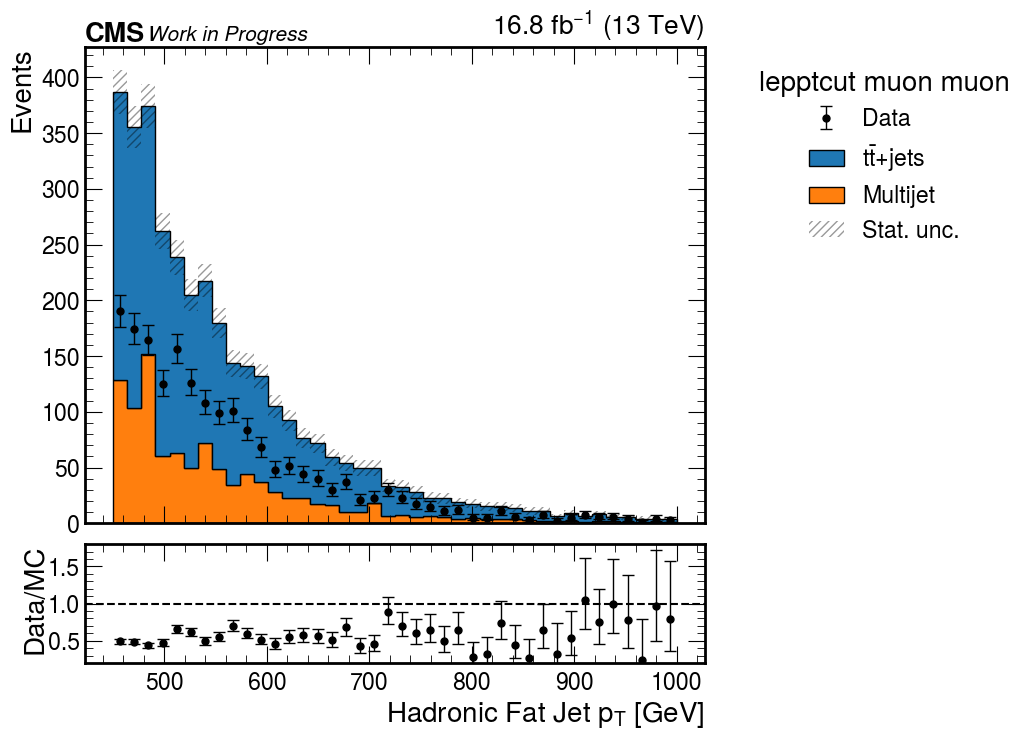

In [67]:
plt.rcParams.update({"font.size": 20})
add_data = True
    
utils.plot_hists(years, channels, hists, vars_to_plot,             
            add_data=True,
            logy=False,
            add_soverb=True,
            only_sig=False,
            mult=1,
            outpath=f".",           
            text_=region,
          )
print()
# get_composition_table(ev, tagger, presel, years, channels)